# Customer Purchase Value Prediction

This notebook aims to predict customer purchase values based on their multi-session behavior across digital touchpoints. We'll analyze user interactions including browser types, traffic sources, device details, and geographical indicators to estimate purchase potential and optimize marketing strategies.

## 1. Required Libraries

First, let's import all the necessary libraries for our analysis.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

## 2. Load and Explore Dataset

Let's load the training and testing datasets and examine their basic properties.

In [66]:
# Load the datasets
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [67]:
X = train_data.drop(columns=['purchaseValue'])
y = train_data['purchaseValue']

In [68]:
feature_names = X.columns.values
label = y.name
print('\nFeature Names:', feature_names)
print('Label Name:', label)


Feature Names: ['trafficSource.isTrueDirect' 'browser' 'device.screenResolution'
 'trafficSource.adContent' 'trafficSource.keyword' 'screenSize'
 'geoCluster' 'trafficSource.adwordsClickInfo.slot'
 'device.mobileDeviceBranding' 'device.mobileInputSelector' 'userId'
 'trafficSource.campaign' 'device.mobileDeviceMarketingName'
 'geoNetwork.networkDomain' 'gclIdPresent' 'device.operatingSystemVersion'
 'sessionNumber' 'device.flashVersion' 'geoNetwork.region' 'trafficSource'
 'totals.visits' 'geoNetwork.networkLocation' 'sessionId' 'os'
 'geoNetwork.subContinent' 'trafficSource.medium'
 'trafficSource.adwordsClickInfo.isVideoAd' 'browserMajor'
 'locationCountry' 'device.browserSize'
 'trafficSource.adwordsClickInfo.adNetworkType' 'socialEngagementType'
 'geoNetwork.city' 'trafficSource.adwordsClickInfo.page'
 'geoNetwork.metro' 'pageViews' 'locationZone' 'device.mobileDeviceModel'
 'trafficSource.referralPath' 'totals.bounces' 'date' 'device.language'
 'deviceType' 'userChannel' 'device.

In [69]:
no_bounce = train_data[train_data['totals.bounces'] != 1]
# Calculate correlation between pageViews and purchaseValue for users who did not bounce
corr = no_bounce['pageViews'].corr(no_bounce['purchaseValue'])
print("Correlation between pageViews and purchaseValue (no bounce):", corr)

Correlation between pageViews and purchaseValue (no bounce): 0.22547226150716898


In [70]:
# from pandas.plotting import scatter_matrix
# attribute_list = ['pageViews', 'totalHits', 'totals.visits', 'purchaseValue']
# scatter_matrix(
#     no_bounce[attribute_list],
#     alpha=0.2,
#     figsize=(10, 10),
#     diagonal='hist',  # Changed from 'kde' to 'hist'
#     color='blue'
# )
# plt.suptitle('Scatter Matrix of Selected Attributes (No Bounce)', fontsize=16, fontweight='bold')
# plt.tight_layout()
# plt.show()  # Added explicit show() call

## 3. Data Preprocessing

In this section, we'll:
1. Handle missing values
2. Encode categorical variables
3. Normalize numerical features

In [71]:
# imputer_1 = SimpleImputer(strategy='constant', fill_value=0)
X['totals.bounces'] = X['totals.bounces'].fillna(0)
X['totals.bounces'].unique()

array([1., 0.])

In [72]:
# continent_avg_hits = X.groupby('geoNetwork.continent')['totalHits'].mean().sort_values(ascending=False)
# print("Average totalHits by continent:\n", continent_avg_hits)
# print("\nContinent with highest average totalHits:", continent_avg_hits.idxmax())

In [73]:
# total_hist = X['totalHits'].unique()
# print("Unique totalHits values:", total_hist)

In [74]:
# imputer_2 = SimpleImputer(strategy='constant', fill_value=False)
X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].fillna(False)
X['trafficSource.isTrueDirect'].unique()

C:\Users\hp\AppData\Local\Temp\ipykernel_15480\1839745741.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X['trafficSource.isTrueDirect'] = X['trafficSource.isTrueDirect'].fillna(False)


array([False,  True])

In [75]:
# X.info()

Text(0.5, 1.0, 'Missing Values in Features')

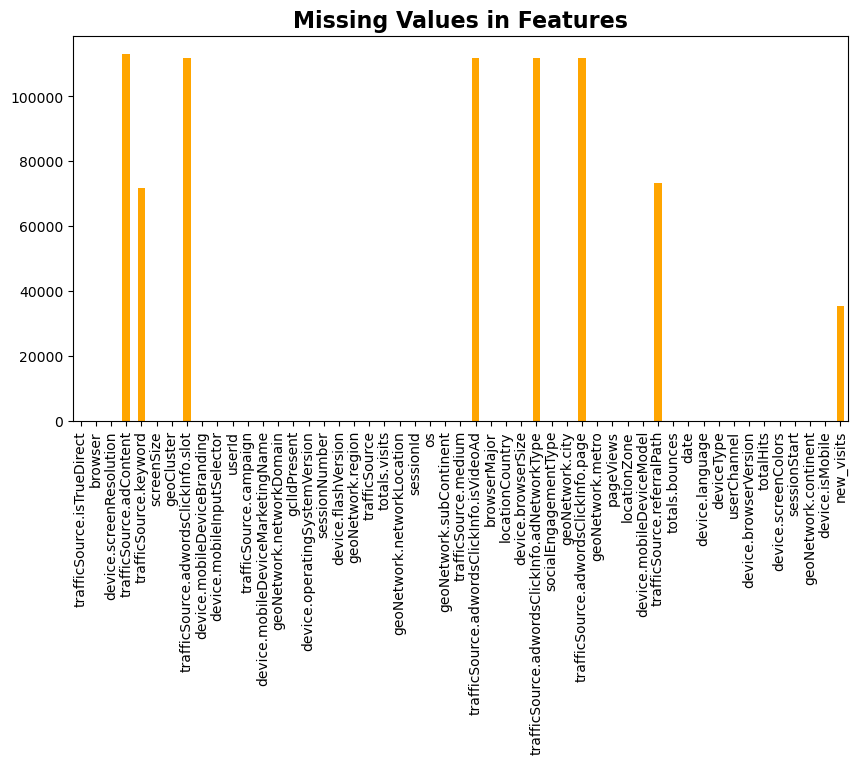

In [76]:
X.isna().sum().plot(kind='bar', figsize=(10, 5), color='orange')
plt.title('Missing Values in Features', fontsize=16, fontweight='bold')

In [77]:
def create_hierarchical_features(df):
    # Create mean purchase value encodings at different geographic levels
    continent_means = df.groupby('geoNetwork.continent')['purchaseValue'].mean()
    country_means = df.groupby(['geoNetwork.continent', 'locationCountry'])['purchaseValue'].mean()
    city_means = df.groupby(['geoNetwork.continent', 'locationCountry', 'geoNetwork.city'])['purchaseValue'].mean()
    
    # Create new features
    df['continent_avg_purchase'] = df['geoNetwork.continent'].map(continent_means)
    df['country_avg_purchase'] = df.apply(lambda x: country_means[x['geoNetwork.continent']][x['locationCountry']], axis=1)
    df['city_avg_purchase'] = df.apply(
        lambda x: city_means[x['geoNetwork.continent']][x['locationCountry']][x['geoNetwork.city']], 
        axis=1
    )
    
    # Calculate difference features
    df['country_continent_diff'] = df['country_avg_purchase'] - df['continent_avg_purchase']
    df['city_country_diff'] = df['city_avg_purchase'] - df['country_avg_purchase']
    
    return df

## 4. Feature Engineering

Let's create new features based on the existing data to improve our model's predictive power.

## 5. Exploratory Data Analysis (EDA)

Let's visualize key patterns and relationships in our data.

## 6. Model Training

Let's prepare our data and train a Random Forest model.

## 7. Model Evaluation

Let's evaluate our model's performance using various metrics.

## 8. Predictions and Submission

Let's generate predictions for the test data and create a submission file.